In [20]:
import numpy as np
import os
import tensorflow as tf
import PIL
import matplotlib
import matplotlib.pyplot as plt

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [21]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-pack

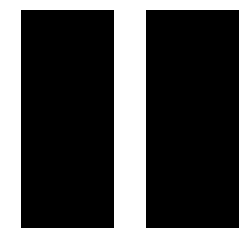

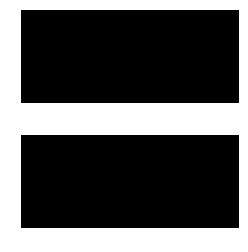

In [22]:
#plotting defined feature maps for convolutional layers
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:,3,0,0] = 1
fmap[3,:,0,1] = 1
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

In [25]:
reset_graph()
#conv. layers isolating features by fmap
X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [26]:
with tf.Session() as sess: 
    output = convolution.eval(feed_dict={X: images})

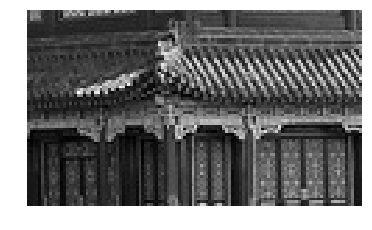

In [27]:
#original image
plot_image(images[0, :, :, 0])
plt.show()

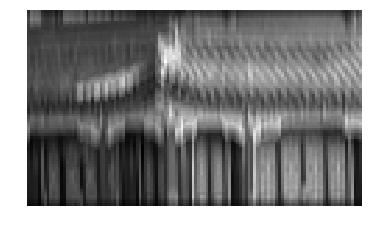

In [29]:
#vertical features
plot_image(output[0, :, :, 0])
plt.show()

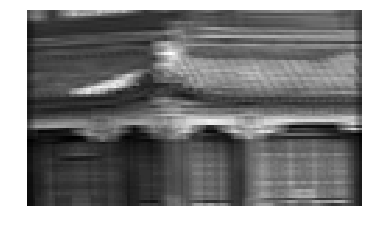

In [30]:
#horz. features
plot_image(output[0, :, :, 1])
plt.show()

In [31]:
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:,3,:,0] = 1 #vertical filter
filters[3,:,:,1] = 1 #horz. filter

#graph with X input and conv. layer applying 2 filters
X = tf.placeholder(tf.float32, shape=(None,height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})
    


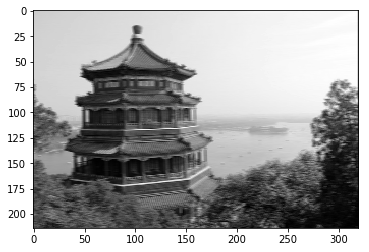

In [32]:
plt.imshow(output[0, :, :, 1], cmap="gray") 
plt.show()

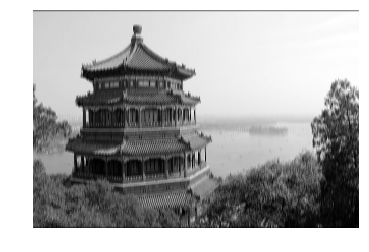

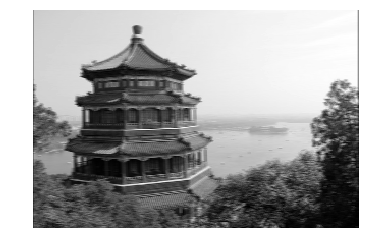

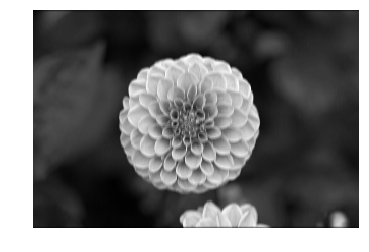

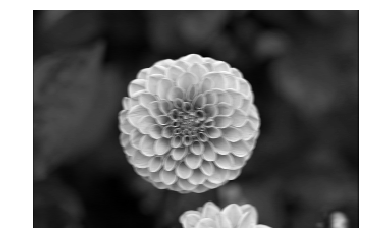

In [33]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])
        plt.show()

In [35]:
reset_graph()

#using tf.layers, creates randomly init. filters for you (kernel)

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2], padding="SAME")

init = tf.global_variables_initializer()

In [36]:
with tf.Session() as sess:
    init.run()
    output= sess.run(conv, feed_dict={X: dataset})

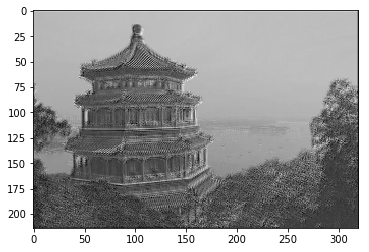

In [37]:
plt.imshow(output[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.show()


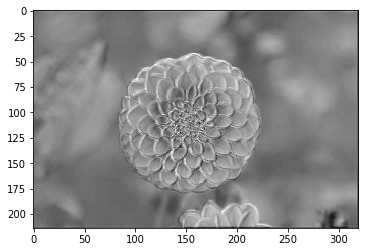

In [38]:
plt.imshow(output[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd feature map
plt.show()


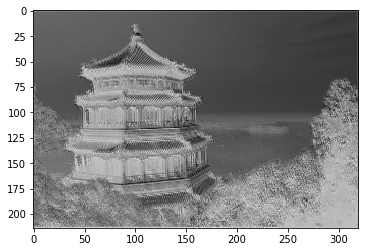

In [39]:
plt.imshow(output[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
plt.show()


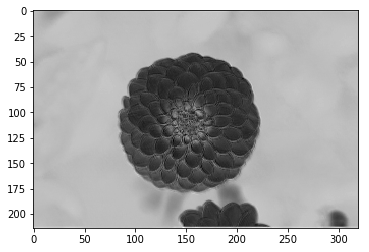

In [40]:
plt.imshow(output[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map
plt.show()


In [44]:
#valid vs same padding
#valid does not use zero padding, some rows or columns may be ignored 
#same uses zero padding when necessary, output neurons = input neurons divided by the stride
#then zeros added as evenly as possible aroudn the inputs
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)

x = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))
filters = tf.constant(filter_primes.reshape(1,6,1,1))

valid_conv= tf.nn.conv2d(x, filters, strides=[1,1,5,1], padding='VALID')
same_conv = tf.nn.conv2d(x, filters, strides=[1,1,5,1], padding='SAME')


In [45]:
with tf.Session() as sess:
    print("Valid:\n", valid_conv.eval())
    print("Same:\n", same_conv.eval())

Valid:
 [[[[184.]
   [389.]]]]
Same:
 [[[[143.]
   [348.]
   [204.]]]]


In [46]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


In [47]:
#problems with CNNS: they have many hyperparameters to tune, and require a lot of RAM
#because backprop requires all the intermediate values created during the forward pass
#during training you must have enough ram for all layers, during inference you can release RAM once you're through a layer


In [48]:
#pooling layer: subsamples input in order to reduce computational load, memory usage and 
#number of params. this also prevents overfitting and gives greater tolerance for location
#invariance
#pooling neurons have no weights, they just aggregate inputs
# the most common type is a max pool (highest value is kept)
#typically you pool over width and height, but you can also pool by depth (reducing channels)

#create pooling layer with 2 x 2 kernel, stride 2, no padding
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X:dataset})


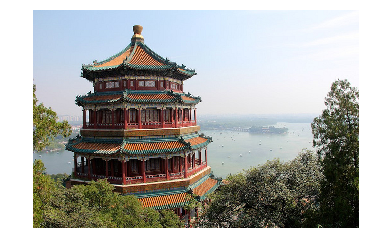

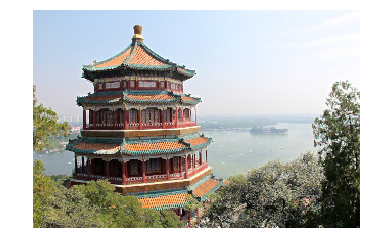

In [50]:
plot_color_image(dataset[0])
plt.show()
    
plot_color_image(output[0])
plt.show()


In [63]:
#mnist with cnn

height = 28 
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 4
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fcl = 64
n_outputs = 10

reset_graph()

In [64]:
with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name ="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")
    
with tf.name_scope("Conv"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize, strides= conv1_stride, 
                             padding=conv1_pad, activation=tf.nn.relu, name="conv1")
    conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize, strides= conv2_stride,
                             padding=conv2_pad, activation=tf.nn.relu, name="conv2")
    
with tf.name_scope("pool"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])
    
with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fcl, activation=tf.nn.relu, name="fc1")
    
with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    y_proba = tf.nn.softmax(logits, name="Y_proba")
    
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("init_saver"):
    init = tf.global_variables_initializer()
    saver= tf.train.Saver()

In [65]:

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [68]:
n_epochs = 20
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: mnist.test.images, y:mnist.test.labels})
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./CNN_model")
        

0 Train accuracy: 0.98 Test accuracy: 0.983
1 Train accuracy: 0.98 Test accuracy: 0.9876
2 Train accuracy: 1.0 Test accuracy: 0.9905
3 Train accuracy: 1.0 Test accuracy: 0.9899
4 Train accuracy: 1.0 Test accuracy: 0.9863
5 Train accuracy: 1.0 Test accuracy: 0.9875
6 Train accuracy: 1.0 Test accuracy: 0.9881
7 Train accuracy: 1.0 Test accuracy: 0.9906
8 Train accuracy: 1.0 Test accuracy: 0.9893
9 Train accuracy: 1.0 Test accuracy: 0.9892
10 Train accuracy: 1.0 Test accuracy: 0.9907
11 Train accuracy: 1.0 Test accuracy: 0.9905
12 Train accuracy: 1.0 Test accuracy: 0.9905
13 Train accuracy: 1.0 Test accuracy: 0.9905
14 Train accuracy: 1.0 Test accuracy: 0.9878
15 Train accuracy: 1.0 Test accuracy: 0.9902
16 Train accuracy: 1.0 Test accuracy: 0.9909
17 Train accuracy: 1.0 Test accuracy: 0.9892
18 Train accuracy: 1.0 Test accuracy: 0.989
19 Train accuracy: 1.0 Test accuracy: 0.9899


In [69]:
file_writer= tf.summary.FileWriter("tf_logs/CNN1", tf.get_default_graph())